In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os


dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

mat_data = loadmat(dataset_path)
print(mat_data.keys())

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/debug
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Rozměry 1D osy X: {x_axis_unique.shape}")
print(f"Rozměry 1D osy Y: {y_axis_unique.shape}")
print(f"Rozměry 2D dat výšek Z: {souradniceZ_mapa.shape}")


terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)
def terMap(px, py):

    points_to_query = np.column_stack((py, px))
    
    return terMap_interpolator(points_to_query)

Rozměry 1D osy X: (2500,)
Rozměry 1D osy Y: (2500,)
Rozměry 2D dat výšek Z: (2500, 2500)


# 4D model

Mapa má původní souřadnice v jednotkách 1e6


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
initial_velocity = torch.from_numpy(initial_velocity_np)

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([ 1.4875e+06,  6.3955e+06,  4.3225e+00, -4.1456e+01])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


## Generování dat
data jsou generována z nenulových počátečních podmínek, ale tato počáteční podmínka je definována proměnnou `system_model.Ex0`, tedy všechny trajektorie jsou generovány z této jedné počáteční podmínky.

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils

# --- KONFIGURACE ---
TRAIN_SEQ_LEN = 100
VALID_SEQ_LEN = 100

NUM_TRAIN_TRAJECTORIES = 500  # Celkový počet trénovacích trajektorií
NUM_VALID_TRAJECTORIES = 100  # Celkový počet validačních trajektorií
BATCH_SIZE = 256

# --- PŘÍPRAVA MODELU ---
# Nastavení hranic pro kontrolu v generátoru (vypočteno v kroku posunu mapy)
system_model.min_x = x_axis_unique.min()
system_model.max_x = x_axis_unique.max()
system_model.min_y = y_axis_unique.min()
system_model.max_y = y_axis_unique.max()
system_model.device = device 

# --- 1. GENEROVÁNÍ TRÉNOVACÍCH DAT ---
print(f"\n=== Generuji {NUM_TRAIN_TRAJECTORIES} TRÉNOVACÍCH trajektorií (délka {TRAIN_SEQ_LEN}) ===")

# Generujeme vše najednou v jednom volání
x_train, y_train = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TRAIN_TRAJECTORIES, 
    seq_len=TRAIN_SEQ_LEN,
    force_initial_state_zero=False
)

print(f"--> Hotovo. Trénovací data: X={x_train.shape}, Y={y_train.shape}")


# --- 2. GENEROVÁNÍ VALIDAČNÍCH DAT ---
print(f"\n=== Generuji {NUM_VALID_TRAJECTORIES} VALIDAČNÍCH trajektorií (délka {VALID_SEQ_LEN}) ===")

x_val, y_val = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_VALID_TRAJECTORIES, 
    seq_len=VALID_SEQ_LEN,
    force_initial_state_zero=False
)

print(f"--> Hotovo. Validační data: X={x_val.shape}, Y={y_val.shape}")
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("\n✅ DataLoadery připraveny. Sady byly odstraněny, pracujeme s celkovým počtem trajektorií.")
print(f"Rozsah trénovacích dat X (min/max): {x_train.min():.2f} / {x_train.max():.2f}")


=== Generuji 500 TRÉNOVACÍCH trajektorií (délka 100) ===
INFO: Generátor dat používá hranice X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Vynucený start v nule: False
  Úspěšně vygenerována trajektorie 50/500 (Pokusů: 50)
  Úspěšně vygenerována trajektorie 100/500 (Pokusů: 100)
  Úspěšně vygenerována trajektorie 150/500 (Pokusů: 150)
  Úspěšně vygenerována trajektorie 200/500 (Pokusů: 200)
  Úspěšně vygenerována trajektorie 250/500 (Pokusů: 250)
  Úspěšně vygenerována trajektorie 300/500 (Pokusů: 300)
  Úspěšně vygenerována trajektorie 350/500 (Pokusů: 350)
  Úspěšně vygenerována trajektorie 400/500 (Pokusů: 400)
  Úspěšně vygenerována trajektorie 450/500 (Pokusů: 450)
  Úspěšně vygenerována trajektorie 500/500 (Pokusů: 500)
------------------------------
Generování dat dokončeno.
Celkový počet pokusů: 500
Úspěšnost (platné trajektorie / pokusy): 100.00%
Celkový počet vygenerovaných trajektorií: torch.Size([500, 100, 4])
--> Hotovo. Trénovací data: X=torch.Size([500, 100

### Vykreslení trénovacích dat

Vykresluji všech 500 trajektorií.


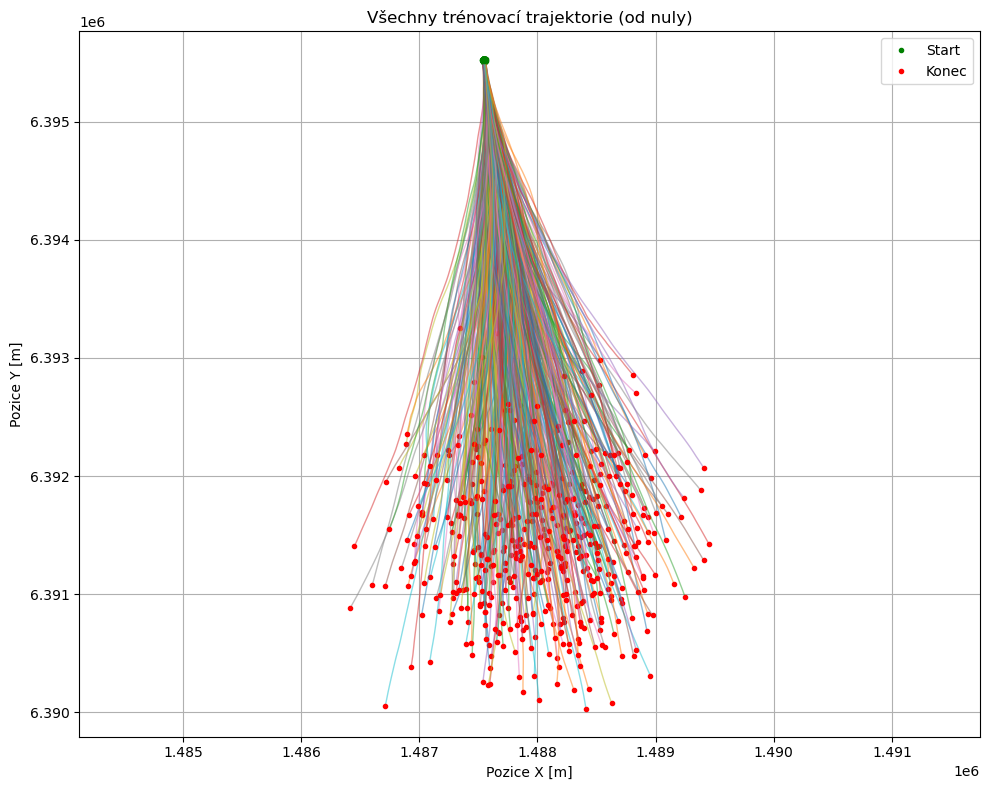

In [6]:
import matplotlib.pyplot as plt

def plot_trajectories(x_data, title="Trajektorie", num_to_plot=None):
    # Převod na numpy pro matplotlib
    x_np = x_data.detach().cpu().numpy()
    
    total_traj = x_np.shape[0]
    
    # Výběr indexů k vykreslení
    if num_to_plot is not None and num_to_plot < total_traj:
        indices = np.random.choice(total_traj, num_to_plot, replace=False)
        print(f"Vykresluji náhodných {num_to_plot} z celkových {total_traj} trajektorií.")
    else:
        indices = range(total_traj)
        print(f"Vykresluji všech {total_traj} trajektorií.")

    plt.figure(figsize=(10, 8))
    
    for i in indices:
        # x_np[i, :, 0] je X souřadnice v čase
        # x_np[i, :, 1] je Y souřadnice v čase
        pos_x = x_np[i, :, 0]
        pos_y = x_np[i, :, 1]
        
        # Vykreslení čáry
        plt.plot(pos_x, pos_y, alpha=0.5, linewidth=1)
        
        # Zvýraznění startu (zelená tečka) a konce (červená tečka)
        plt.plot(pos_x[0], pos_y[0], 'go', markersize=3, label='Start' if i == indices[0] else "")
        plt.plot(pos_x[-1], pos_y[-1], 'ro', markersize=3, label='Konec' if i == indices[0] else "")

    plt.title(title)
    plt.xlabel("Pozice X [m]")
    plt.ylabel("Pozice Y [m]")
    plt.grid(True)
    plt.axis('equal') # Aby nedošlo ke zkreslení poměru stran
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
# 1. Vykreslení všech trénovacích dat (může být nepřehledné, pokud jich je moc)
plot_trajectories(x_train, title="Všechny trénovací trajektorie (od nuly)")

# 2. Nebo vykreslení náhodného vzorku (např. 50 trajektorií), pro lepší přehled
# plot_trajectories(x_train, title="Ukázka 50 trénovacích trajektorií", num_to_plot=50)

# 3. Můžete zkontrolovat i validační data
# plot_trajectories(x_val, title="Validační trajektorie", num_to_plot=20)

### Trénink KalmanNetu

poznámky:
- KalmanNet dostává při tréninku pro každou novou trajektorii přesnou informaci o počátečním stavu. Ten je předáván KalmanNetu pomocí funkce reset().
- KalmanNet má inicializovanou výstupní vrstvu `output_final_linear` s téměř nulovými váhami. To pomáhá potlačit extrémní exploze loss na začátku tréninku. 

In [14]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import StateKalmanNet_v2 
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

state_knet2 = StateKalmanNet_v2(
    system_model=system_model, 
    device=device,
    hidden_size_multiplier=8,
    output_layer_multiplier=4,
    num_gru_layers=1,
    gru_hidden_dim_multiplier=8
    ).to(device)

trained_model = trainer.train_state_KalmanNet_sliding_window(
    model=state_knet2,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=250,
    lr=1e-3,
    clip_grad=1.0,
    early_stopping_patience=30,
    tbptt_k=2,
    tbptt_w=8,
    optimizer_=torch.optim.AdamW,
    weight_decay_=1e-3,

)
print(trained_model)

DEBUG: Vrstva 'output_final_linear' inicializována na nuly (Start K=0).
INFO: Detekováno z atributu modelu, že vrací kovarianci: False
INFO: Spouštím trénink s TBPTT(k=2, w=8)
Nové nejlepší model uloženo! Epoch [1/250], Train Loss: 89213.628884, Val Loss: 10097.387695
Nové nejlepší model uloženo! Epoch [2/250], Train Loss: 5736.238477, Val Loss: 2530.670898
Nové nejlepší model uloženo! Epoch [3/250], Train Loss: 1901.964843, Val Loss: 1170.811401
Nové nejlepší model uloženo! Epoch [4/250], Train Loss: 903.758930, Val Loss: 631.330444
Epoch [5/250], Train Loss: 486.850562, Val Loss: 381.250702
Nové nejlepší model uloženo! Epoch [5/250], Train Loss: 486.850562, Val Loss: 381.250702
Nové nejlepší model uloženo! Epoch [6/250], Train Loss: 299.111371, Val Loss: 246.324432
Nové nejlepší model uloženo! Epoch [7/250], Train Loss: 196.467755, Val Loss: 172.062134
Nové nejlepší model uloženo! Epoch [8/250], Train Loss: 135.090609, Val Loss: 123.304802
Nové nejlepší model uloženo! Epoch [9/250], 

## Test na testovacích datech
- porovnání KalmanNetu, vůči UKF a PF
- PF by potřeboval pro přesnější odhad tak 10x více vzorků, ale to zde není předmětem testování

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


TEST_SEQ_LEN = 600 
NUM_TEST_TRAJ = 5

print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")

x_test, y_test = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ,
    seq_len=TEST_SEQ_LEN,
    force_initial_state_zero=False
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

print("y shape:", y_test.shape) # Mělo by být [1, 20, 1]
print("x shape:", x_test.shape) # Mělo by být [1, 20, 3]

ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=20000)

all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet2_cpu = []

all_knet_diagnostics_cpu = []
print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

state_knet2.eval()


with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        classic_knet2_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet2.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet2_preds.append(x_filtered_t)
        full_x_hat_classic_knet2 = torch.cat([initial_state, torch.cat(classic_knet2_preds, dim=0)], dim=0)
        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_classic_knet2_cpu.append(full_x_hat_classic_knet2.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []


mse_pf_sir_ideal, anees_pf_sir_ideal = [], []
mse_classic_knet2 = []

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat_full, P_hat_full):
            if x_hat_full.shape[0] != x_true.shape[0] or P_hat_full.shape[0] != x_true.shape[0]:
                 raise ValueError(f"Nesoulad délek! x_true: {x_true.shape[0]}, x_hat: {x_hat_full.shape[0]}, P_hat: {P_hat_full.shape[0]}")


            mse = F.mse_loss(x_hat_full[1:], x_true[1:]).item()

            anees = utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0),
                x_hat_full[1:].unsqueeze(0),
                P_hat_full[1:].unsqueeze(0)
            )
            return mse, anees

        mse = F.mse_loss(all_x_hat_classic_knet2_cpu[i][1:], x_true[1:]).item(); mse_classic_knet2.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
        print("\n" + "="*80)
        print(f"trajektorie: {i + 1}/{NUM_TEST_TRAJ}")
        print("="*80)
        print("-" * 80)
        print(f"{'KNet2 (pouze MSE)':<35} | {(mse_classic_knet2[i]):<20.4f} | {'N/A':<20}")
        print(f"{'UKF (Ideální model)':<35} | {(mse_ukf_ideal[i]):<20.4f} | {(anees_ukf_ideal[i]):<20.4f}")
        print(f"{'PF-SIR (Ideální model)':<35} | {(mse_pf_sir_ideal[i]):<20.4f} | {(anees_pf_sir_ideal[i]):<20.4f}")
        print("="*80)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]


print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
print(f"{'KNet2 (pouze MSE)':<35} | {avg(mse_classic_knet2):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)


Generuji 5 testovacích trajektorií o délce 600...
INFO: Generátor dat používá hranice X:[1476611.42-1489541.47], Y:[6384032.63-6400441.34]
INFO: Vynucený start v nule: False
  Úspěšně vygenerována trajektorie 1/5 (Pokusů: 29)
  Úspěšně vygenerována trajektorie 2/5 (Pokusů: 41)
  Úspěšně vygenerována trajektorie 3/5 (Pokusů: 64)
  Úspěšně vygenerována trajektorie 4/5 (Pokusů: 100)
  Úspěšně vygenerována trajektorie 5/5 (Pokusů: 121)
------------------------------
Generování dat dokončeno.
Celkový počet pokusů: 121
Úspěšnost (platné trajektorie / pokusy): 4.13%
Celkový počet vygenerovaných trajektorií: torch.Size([5, 600, 4])
Generování dat dokončeno.
y shape: torch.Size([5, 600, 3])
x shape: torch.Size([5, 600, 4])

Vyhodnocuji modely na 5 testovacích trajektoriích...
PF-SIR (ideální model) dokončen pro trajektorii 1/5.
Dokončena trajektorie 1/5...
PF-SIR (ideální model) dokončen pro trajektorii 2/5.
Dokončena trajektorie 2/5...
PF-SIR (ideální model) dokončen pro trajektorii 3/5.
Doko

## Diagnostika na testovacích trajektoriích.

proměnná `index` reprezentuje konkrétní testovací trajektorii

In [ ]:
import matplotlib.pyplot as plt

map_bounds = {
    'x_min': 1476611.42,
    'x_max': 1489541.47,
    'y_min': 6384032.63,
    'y_max': 6400441.34
}

index = 0
if index < 0: index = 0
try:
    knet_diagnostics = all_knet_diagnostics_cpu[index]
    plot_diagnostics = True
except (NameError, IndexError):
    print("Varování: 'all_knet_diagnostics_cpu' nenalezeno nebo je prázdné. Diagnostické grafy (K, h, inovace) nebudou vykresleny.")
    plot_diagnostics = False
    plot_gains = False

x_true_plot = all_x_true_cpu[index].numpy()
x_true_tensor = all_x_true_cpu[index]
x_pf_tensor = all_x_hat_pf_sir_ideal_cpu[index]
x_knet2_tensor = all_x_hat_classic_knet2_cpu[index]
x_knet_tensor = x_knet2_tensor
squared_error = (x_knet_tensor - x_true_tensor)**2
rmse_per_step = torch.sqrt(squared_error).numpy()

num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps)
gain_time_axis = np.arange(1, num_steps)

if plot_diagnostics:
    try:
        kalman_gains_history = knet_diagnostics['K_history']
        gains_col0_cpu = [K[0, :, 0].cpu().numpy() for K in kalman_gains_history] 
        gains_col0_np = np.array(gains_col0_cpu)
        plot_gains = True
        
        if gains_col0_np.shape[0] != len(gain_time_axis):
            print(f"Varování: Délka historie zisku ({gains_col0_np.shape[0]}) neodpovídá časové ose ({len(gain_time_axis)}). Graf zisku K nebude vykreslen.")
            plot_gains = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování Kalmanova zisku: {e}. Grafy K nebudou vykresleny.")
        plot_gains = False

    try:
        h_history = knet_diagnostics['h_history']

        h_norms = [torch.norm(h.squeeze(1)).item() for h in h_history] 
        plot_h_norm = True
        
        if len(h_norms) != len(time_axis):
            print(f"Varování: Délka historie stavu h ({len(h_norms)}) neodpovídá časové ose ({len(time_axis)}). Graf h nebude vykreslen.")
            plot_h_norm = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování skrytého stavu h: {e}. Graf h nebude vykreslen.")
        plot_h_norm = False

    try:
        innovation_history = knet_diagnostics['innovation_history']
        innov_norms = [torch.norm(innov.squeeze(0)).item() for innov in innovation_history] 
        plot_innov_norm = True
        
        if len(innov_norms) != len(gain_time_axis):
            print(f"Varování: Délka historie inovace ({len(innov_norms)}) neodpovídá časové ose ({len(gain_time_axis)}). Graf inovace nebude vykreslen.")
            plot_innov_norm = False
            
    except Exception as e:
        print(f"Nastala chyba při zpracování inovace: {e}. Graf inovace nebude vykreslen.")
        plot_innov_norm = False
        

state_labels = [
    'Pozice X [m]',
    'Pozice Y [m]',
    'Rychlost vX [m/s]',
    'Rychlost vY [m/s]'
]
error_labels = [
    'RMSE Pozice X [m]',
    'RMSE Pozice Y [m]',
    'RMSE Rychlost vX [m/s]',
    'RMSE Rychlost vY [m/s]'
]
gain_labels = [
    'K[0,0] (Výška -> Pozice X)',
    'K[1,0] (Výška -> Pozice Y)',
    'K[2,0] (Výška -> Rychlost vX)',
    'K[3,0] (Výška -> Rychlost vY)'
]
diagnostic_labels = {
    'h_norm': 'L2 Norma skrytého stavu $h_t$',
    'innov_norm': 'L2 Norma inovace $\Delta y_t$'
}


fig1, axes1 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig1.suptitle(f'Detailní porovnání odhadů stavu v čase (Trajektorie {index+1})', fontsize=16)


fig2, axes2 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
fig2.suptitle(f'RMSE odhadu pro jednotlivé složky stavu v čase (KNet, Traj. {index+1})', fontsize=16)


if plot_gains:
    fig3, axes3 = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    fig3.suptitle(f'Vývoj prvků 1. sloupce Kalmanova zisku KNet v čase (Traj. {index+1})', fontsize=16)

if plot_diagnostics and plot_h_norm and plot_innov_norm:
    fig4, axes4 = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    fig4.suptitle(f'Diagnostika vnitřních stavů KNet v čase (Traj. {index+1})', fontsize=16)
else:
    plot_h_norm = False
    plot_innov_norm = False



for i in range(4):
    ax1 = axes1[i]
    ax1.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.0, label='Referenční hodnota')
    ax1.plot(time_axis, x_knet_tensor[:, i].numpy(), 'g--', linewidth=1.5, label='Odhad KNet')
    ax1.plot(time_axis, x_pf_tensor[:, i].numpy(), 'm:', linewidth=1.5, label='Odhad PF-SIR')
    ax1.plot(time_axis, x_knet2_tensor[:, i].numpy(), 'b-.', linewidth=1.5, label='Odhad KNet2')
    ax1.set_ylabel(state_labels[i])
    ax1.grid(True)
    ax1.legend()

    if i == 0: 
        ax1.axhline(map_bounds['x_min'], color='grey', linestyle=':', linewidth=1.5, label='Hranice mapy X')
        ax1.axhline(map_bounds['x_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Přidávám hranice X ({map_bounds['x_min']:.2f}, {map_bounds['x_max']:.2f}) do grafu Pozice X.")
    elif i == 1: 
        ax1.axhline(map_bounds['y_min'], color='grey', linestyle=':', linewidth=1.5, label='Hranice mapy Y')
        ax1.axhline(map_bounds['y_max'], color='grey', linestyle=':', linewidth=1.5)
        print(f"INFO: Přidávám hranice Y ({map_bounds['y_min']:.2f}, {map_bounds['y_max']:.2f}) do grafu Pozice Y.")
    
    ax2 = axes2[i]
    ax2.plot(time_axis, rmse_per_step[:, i], 'b-', linewidth=1.5, label=f'RMSE KNet (Avg: {np.mean(rmse_per_step[1:, i]):.2f})')
    ax2.set_ylabel(error_labels[i])
    ax2.grid(True)
    ax2.legend()

    if plot_gains:
         ax3 = axes3[i]
         ax3.plot(gain_time_axis, gains_col0_np[:, i], 'k-', linewidth=1.5, label=f'{gain_labels[i]} (Avg: {np.mean(gains_col0_np[:, i]):.4f})')
         ax3.set_ylabel(gain_labels[i])
         ax3.grid(True)
         ax3.legend()

if plot_h_norm:
    ax4_h = axes4[0]
    ax4_h.plot(time_axis, h_norms, 'darkorange', linewidth=1.5, label=f'Norma $h_t$')
    ax4_h.set_ylabel(diagnostic_labels['h_norm'])
    ax4_h.grid(True)
    ax4_h.legend()
    ax4_h.set_yscale('log') 

if plot_innov_norm:
    ax4_innov = axes4[1]
    ax4_innov.plot(gain_time_axis, innov_norms, 'purple', linewidth=1.5, label=f'Norma $\Delta y_t$')
    ax4_innov.set_ylabel(diagnostic_labels['innov_norm'])
    ax4_innov.set_xlabel('Časový krok [s]')
    ax4_innov.grid(True)
    ax4_innov.legend()
    ax4_innov.set_yscale('log')

axes1[-1].set_xlabel('Časový krok [s]')
axes2[-1].set_xlabel('Časový krok [s]')
if plot_gains:
    axes3[-1].set_xlabel('Časový krok [s]')

fig1.tight_layout(rect=[0, 0.03, 1, 0.96])
fig2.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_gains:
    fig3.tight_layout(rect=[0, 0.03, 1, 0.96])
if plot_h_norm or plot_innov_norm:
    fig4.tight_layout(rect=[0, 0.03, 1, 0.96])

plt.show()